# Welcome to Trajectory Prediction demo - Inference


### Pipeline of TP:


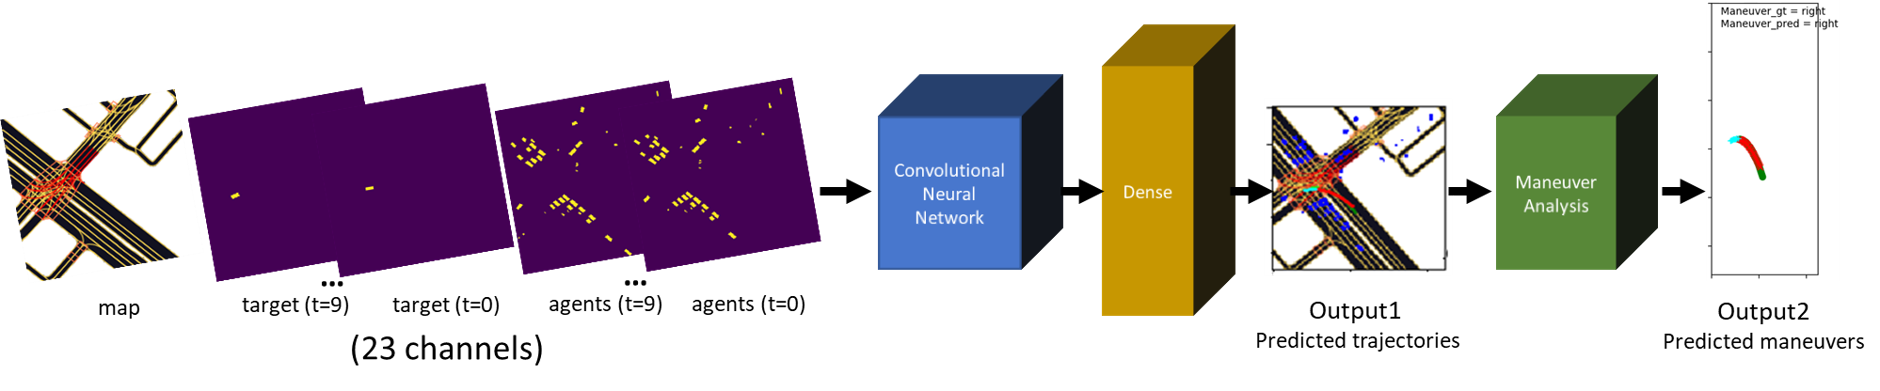




### Dataset: LYFT (170,000 sequences)

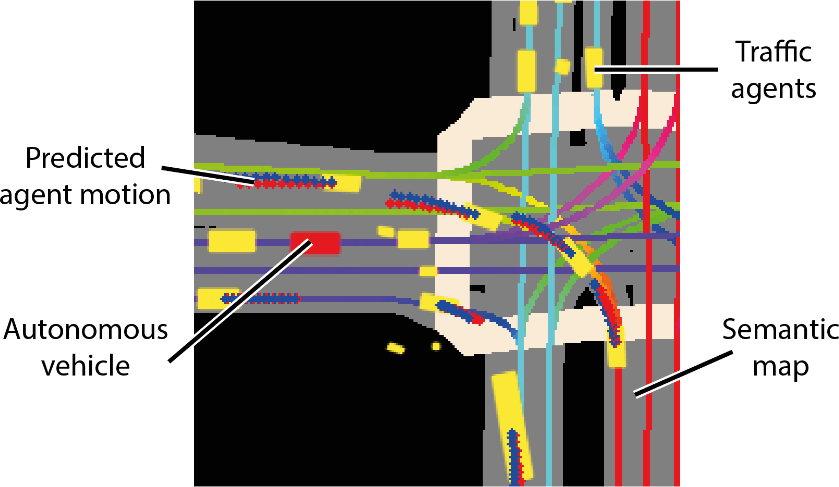


#### Collect Hardware info

In [ ]:
%cat /proc/cpuinfo | head -n 10

#### Collect Software info

In [ ]:
import torch.utils.collect_env as environ

print(environ.main())

In [ ]:
import config
import torch
from resnet50_dropout import resnet50
from dataset import test_loader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import time
from plot_trajectory import trajectories_plot

sequence_length = config.SEQ_LENGTH
past_trajectory = config.HISTORY
history_frames = past_trajectory*2 + 3
total_maneuvers = ["none", "straight", "right", "left"]

print("sequence_length", sequence_length)
print("past_trajectory", past_trajectory)
print("Future prediction", sequence_length - past_trajectory)

#set random seeds
np.random.seed(config.seed)
torch.manual_seed(config.seed)

print(config.DEVICE)


## Model based on Resnet-50 architecture

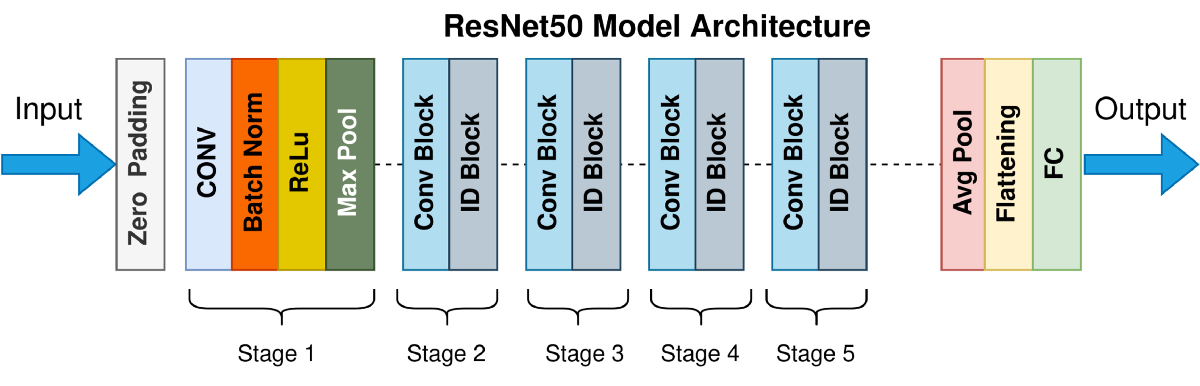



In [ ]:
# Model Creation
def build_model() -> torch.nn.Module:
    # load pre-trained Conv2D model
    # '''
    model = resnet50(pretrained=True, p=config.dropout_prob)

    # change input channels number to match the rasterizer's output
    if config.DATASET == "SHIFT":
        num_in_channels = 25
    else:
        num_in_channels = 3 + (2*past_trajectory)

    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states

    if config.future_prediction > 0:
        num_targets = 2 * config.future_prediction
    else:
        num_targets = 2 * (sequence_length - past_trajectory)

    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model
    

class WrappedModel(nn.Module):
	def __init__(self, module):
		super(WrappedModel, self).__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

In [ ]:
model = build_model().to(config.DEVICE)
model = WrappedModel(model) #the model was trained on gpu with dataparallel,, need to add this to run on cpu.

# # load the model checkpoint
print('Loading checkpoint')
checkpoint = torch.load(config.model_path, map_location=config.DEVICE)

model_epoch = checkpoint['epoch']
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])#, strict=False) # Error(s) in loading state_dict for ResNet: -> added strict-False
print('Loaded checkpoint at epoch', model_epoch)

### Metric: Average displacement error (ADE) & Final displacement Error (FDE)

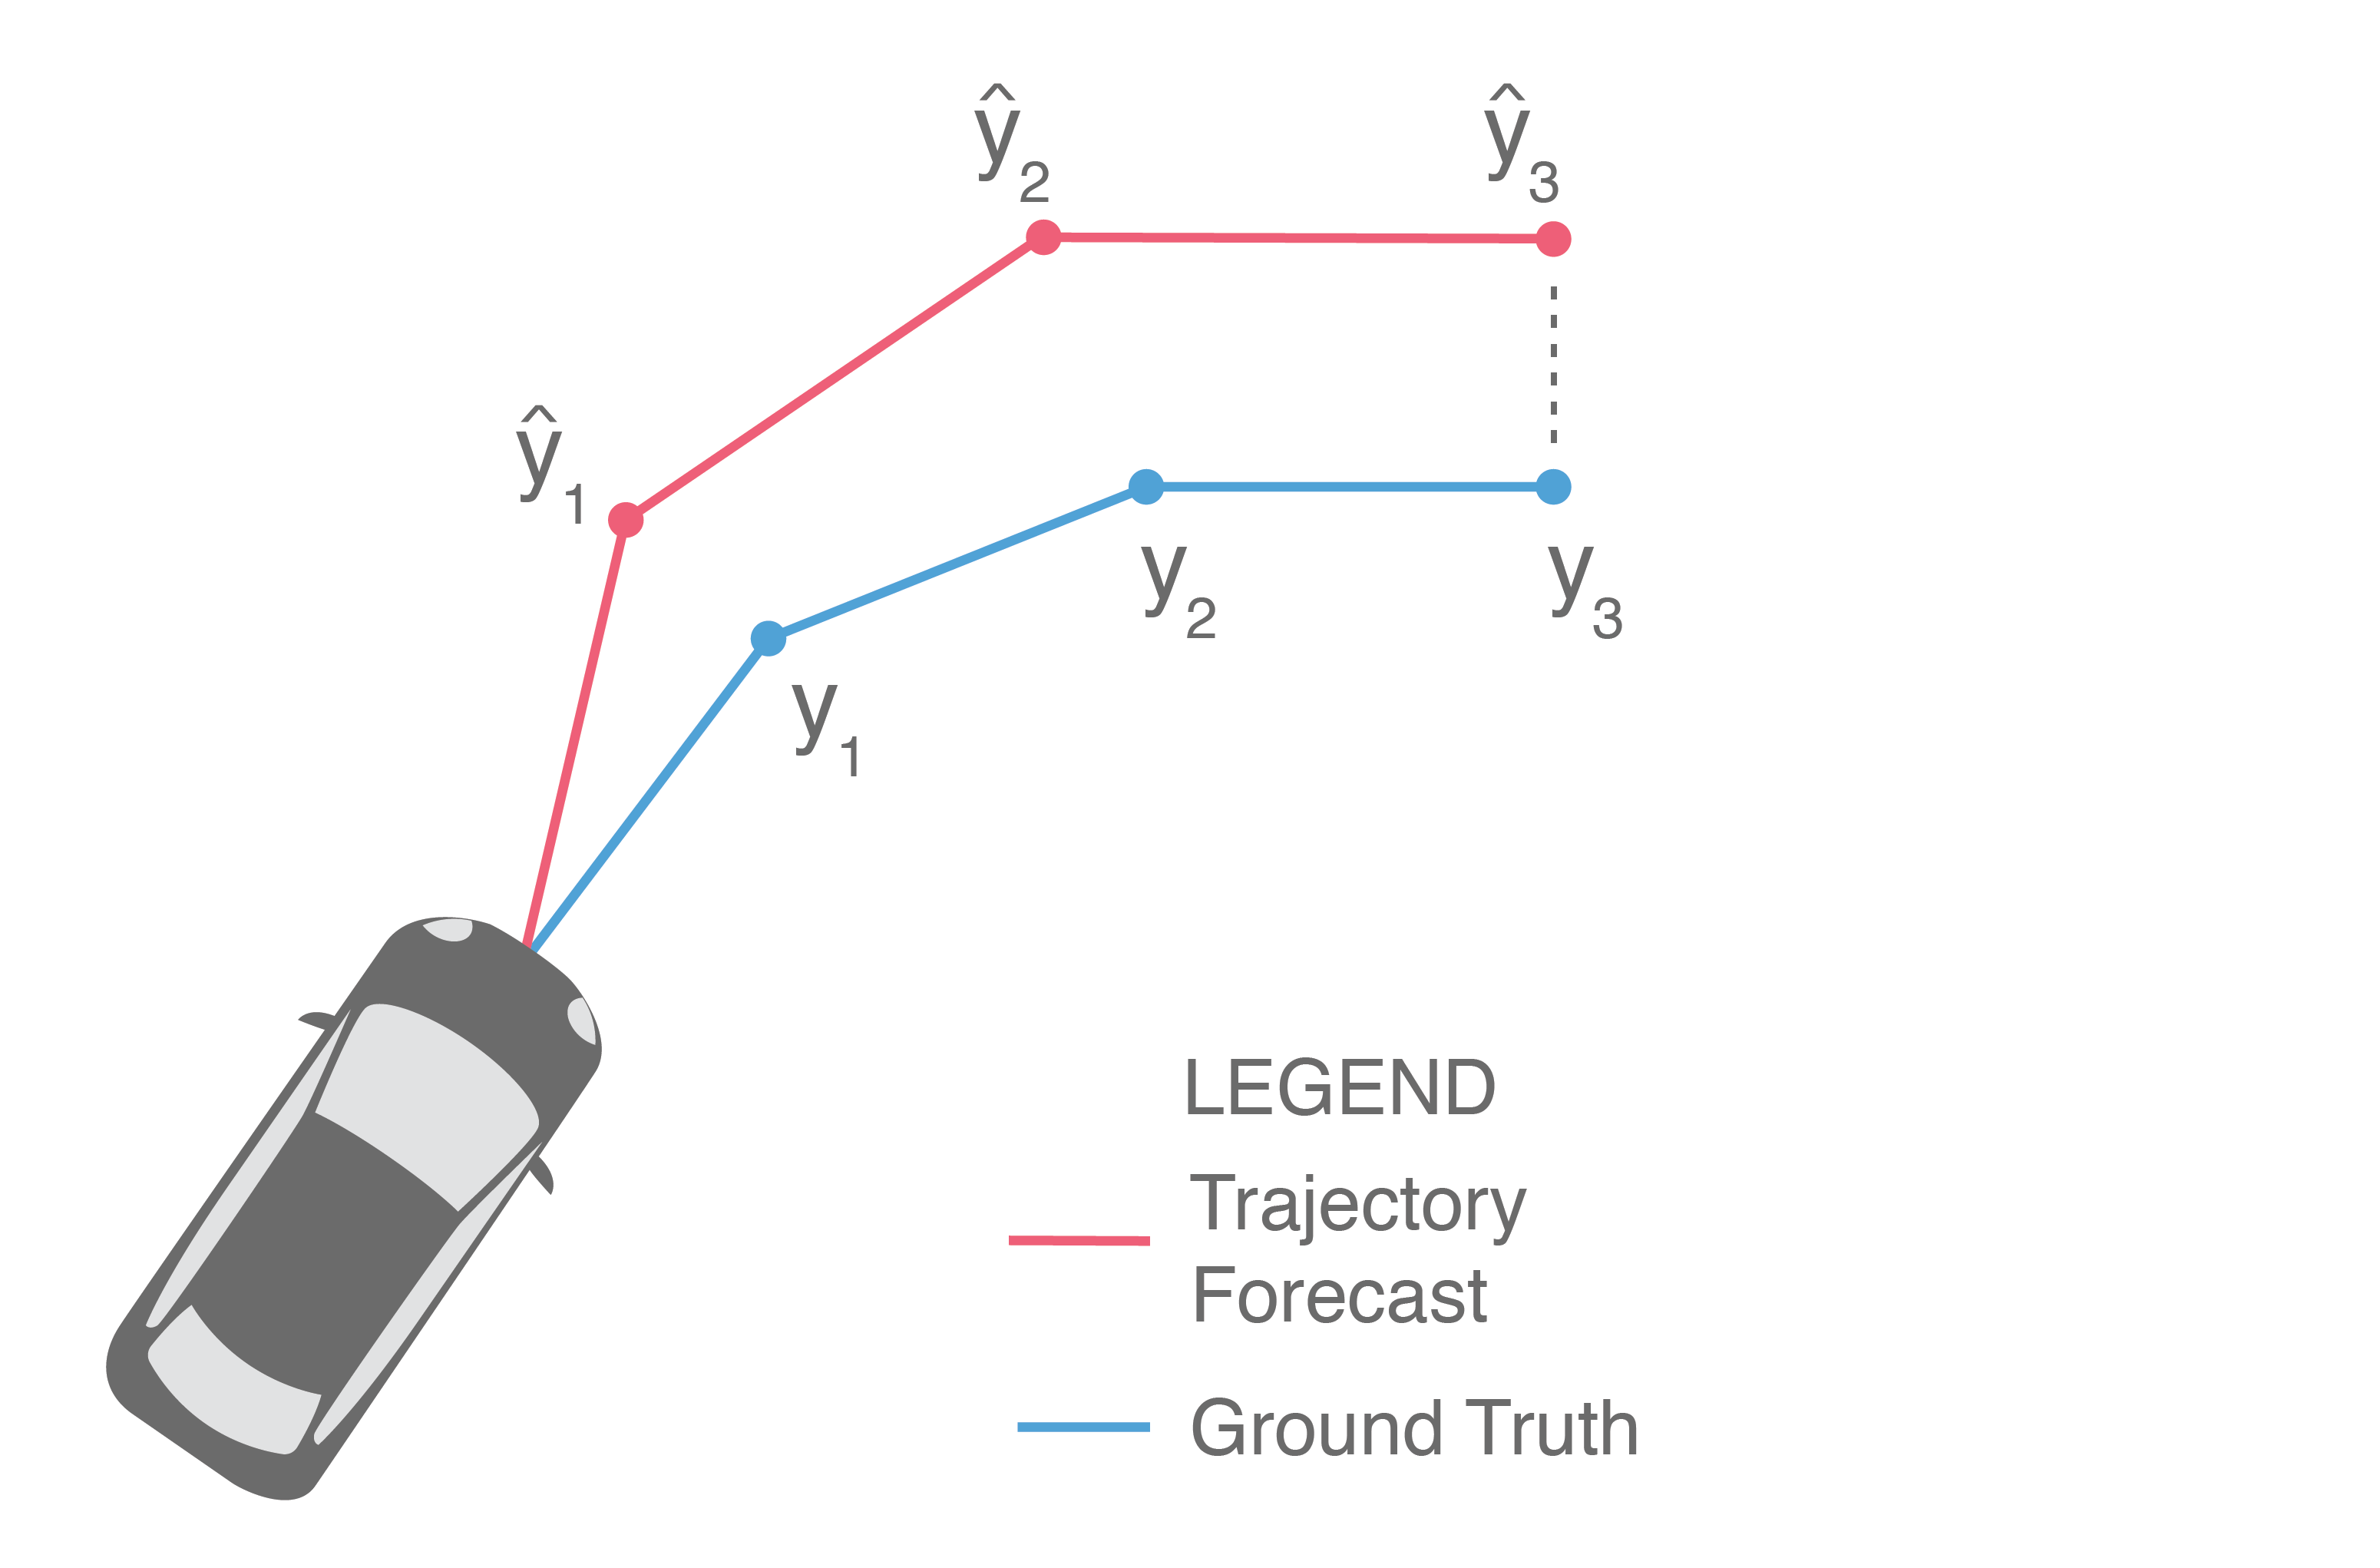

In [ ]:
def calculate_ade(outputs, targets):

    displacement = np.linalg.norm(outputs - targets, axis=1) 
    ade = np.mean(displacement)   
    return ade

def calculate_fde(outputs, targets):

    fde = np.linalg.norm(outputs[outputs.shape[0]-1] - targets[outputs.shape[0]-1])
    return fde

### Inference on test dataloader

In [ ]:

def evaluate(model, dataloader, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures, mixedprecision):

    test_time_list = []

    with torch.no_grad():

        for i, data in enumerate(dataloader):

            # data = data.to(memory_format=torch.channels_last)

            image, keypoints, availability, seq_id, image_agent, centroid_current, history_traj, history_traj_availability, maneuver_label = data['image'].to(config.DEVICE), torch.squeeze(data['keypoints'].to(config.DEVICE)), torch.squeeze(data['availability'].to(config.DEVICE)), torch.squeeze(data['seq_id'].to(config.DEVICE)), torch.squeeze(data['current_agent_i'].to(config.DEVICE)), torch.squeeze(data['centroid_current'].to(config.DEVICE)), torch.squeeze(data['history_traj'].to(config.DEVICE)), torch.squeeze(data['history_traj_availability'].to(config.DEVICE)), torch.squeeze(data['maneuver_label'].to(config.DEVICE))

            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            keypoints = keypoints.detach().cpu().numpy()
            keypoints = ((keypoints + 1)/2)*int(config.IMAGE_SIZE)

            availability = availability.view(availability.size(0), -1)
            availability = availability.detach().cpu().numpy()

            if config.DATASET != "SHIFT":
                history_traj = history_traj.view(history_traj.size(0), -1)
                history_traj_availability = history_traj_availability.view(history_traj_availability.size(0), -1)
                image_agent = image_agent.detach().cpu().numpy()
                centroid_current = centroid_current.detach().cpu().numpy()
                history_traj = history_traj.detach().cpu().numpy()
                history_traj_availability = history_traj_availability.detach().cpu().numpy()
                maneuver_label = maneuver_label.detach().cpu().numpy()

            outputs_list = []
            ade_final = 1000
            fde_final = 1000

            model.eval()

            # outputs, _ = model.forward(image)
            t1 = time.time()

            if mixedprecision:
                with torch.cpu.amp.autocast():
                    outputs, _ = model(image) #outputs=model(image).reshape(keypoints.shape)-->since we flattened the keypoints, no need for reshaping
            else:
                outputs, _ = model(image) #outputs=model(image).reshape(keypoints.shape)-->since we flattened the keypoints, no need for reshaping

            test_time = time.time() - t1

            outputs = outputs.view(keypoints.shape[0], -1)
            outputs = outputs.detach().cpu().numpy()
            outputs = ((outputs + 1)/2)*int(config.IMAGE_SIZE)
            outputs = outputs[np.where(availability == 1)]
            keypoints1 = keypoints[np.where(availability == 1)]
            outputs_list.append(outputs)
            ade_value = calculate_ade(outputs.reshape(-1,2), keypoints1.reshape(-1,2)) * config.IMAGE_FACTOR
            fde_value = calculate_fde(outputs.reshape(-1,2), keypoints1.reshape(-1,2)) * config.IMAGE_FACTOR

            test_time_list.append(test_time)
    
            image = image.detach().cpu().numpy()

            keypoints = keypoints[np.where(availability == 1)]
            keypoints = keypoints.reshape(-1,2)

            if config.DATASET != "SHIFT":
                history_traj = history_traj[np.where(history_traj_availability == 1)]
                history_traj = history_traj.reshape(-1,2)

            outputs_mean = np.mean(np.asarray(outputs_list), axis=0)
            outputs_var = np.std(np.asarray(outputs_list), axis=0)

            # outputs_mean = np.asarray(outputs_list[0])
            outputs_mean = outputs_mean.reshape(-1,2)
            outputs_var = outputs_var.reshape(-1,2)
            outputs_var_mean = np.mean(outputs_var, axis=1)
            total_uncertainty = np.mean(outputs_var_mean)
            
            ade = calculate_ade(outputs_mean, keypoints) * config.IMAGE_FACTOR
            fde = calculate_fde(outputs_mean, keypoints) * config.IMAGE_FACTOR

            final_index = -1

            ade_list.append(ade)
            fde_list.append(fde)
            variance_list.append(total_uncertainty)

            maneuver_label = 0
            maneuver_pred = 0

            print("seq_id, ADE, FDE, maneuver_gt, maneuver_pred, outputs_var_mean = ", seq_id.item(), ade, fde, maneuver_label, maneuver_pred, total_uncertainty)
            f.write(str(seq_id.item())+","+str(ade)+","+str(fde)+","+str(maneuver_label)+","+str(maneuver_pred)+","+str(total_uncertainty)+","+str(noise)+"\n")

            trajectories_plot(image, outputs_mean, keypoints, seq_id.item(), image_agent, centroid_current, ade, fde, history_traj, maneuver_label, maneuver_pred, outputs_list, outputs_var_mean, final_index, noise, plot_figures)

        return ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list


### Run Configuration

In [ ]:
counter_1 = 0
ade_list = []
fde_list = []
maneuver_gt = []
maneuver_outputs = []
variance_list = []

f=open(f"{config.plots}/ade-fde.txt","w+")
f.write("seq_id,ade,fde,maneuver_gt,maneuver_pred\n")

test_loader_iter = test_loader

noise = False
plot_figures = True
mixedprecision = False

# validatioon function
ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures, mixedprecision)

cm = confusion_matrix(maneuver_gt, maneuver_outputs)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())

f.write("total_ADE =" + str(sum(ade_list)/len(ade_list)) +"\n")
f.write("total_FDE =" + str(sum(fde_list)/len(fde_list)) +"\n")
f.write("total_uncertainty =" + str(sum(variance_list)/len(variance_list)) +"\n")
f.write("total_model_time =" + str(sum(test_time_list)/len(test_time_list)) +"\n")

print("total_ADE", sum(ade_list)/len(ade_list))
print("total_FDE", sum(fde_list)/len(fde_list))
print("total_uncertainty", sum(variance_list)/len(variance_list))
print("total_model_time =", sum(test_time_list)/len(test_time_list))

total_ADE = sum(ade_list)/len(ade_list)



## Optimize with Intel Extension for Pytorch

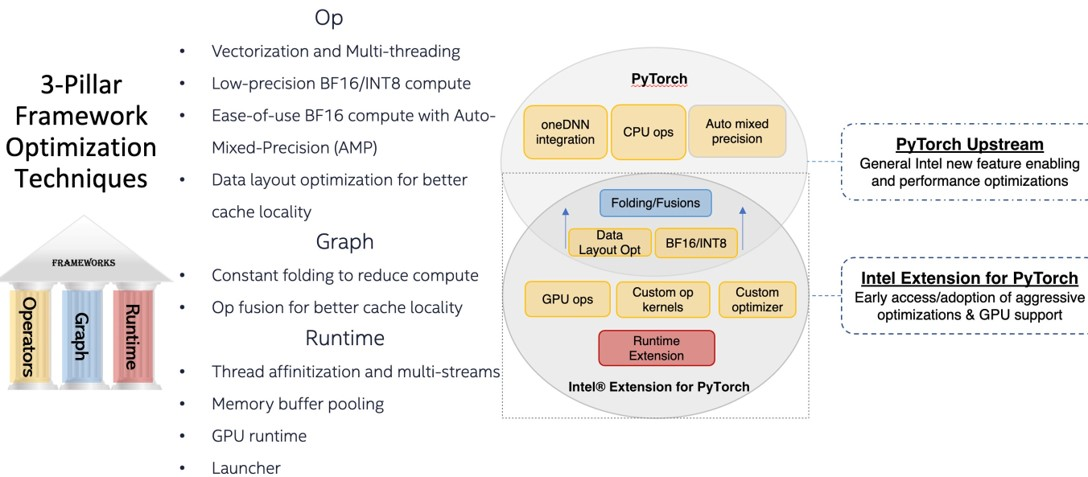

In [ ]:
#with IPEX
import intel_extension_for_pytorch as ipex
model_ipex = ipex.optimize(model)

counter_1 = 0
ade_list = []
fde_list = []
maneuver_gt = []
maneuver_outputs = []
variance_list = []

f=open(f"{config.plots}/ade-fde_ipex.txt","w+")
f.write("seq_id,ade,fde,maneuver_gt,maneuver_pred\n")

test_loader_iter = test_loader

noise = False
plot_figures = True
mixedprecision = False
# validatioon function
ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list_ipex = evaluate(model_ipex, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures, mixedprecision)

cm = confusion_matrix(maneuver_gt, maneuver_outputs)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())

f.write("total_ADE =" + str(sum(ade_list)/len(ade_list)) +"\n")
f.write("total_FDE =" + str(sum(fde_list)/len(fde_list)) +"\n")
f.write("total_uncertainty =" + str(sum(variance_list)/len(variance_list)) +"\n")
f.write("total_model_time =" + str(sum(test_time_list_ipex)/len(test_time_list_ipex)) +"\n")

print("total_ADE", sum(ade_list)/len(ade_list))
print("total_FDE", sum(fde_list)/len(fde_list))
print("total_uncertainty", sum(variance_list)/len(variance_list))
print("total_model_time =", sum(test_time_list_ipex)/len(test_time_list_ipex))

total_ADE_ipex = sum(ade_list)/len(ade_list)



### Performance Graph

In [ ]:
#show performance boost
time_test = sum(test_time_list)/len(test_time_list) #0.18365324868096244
time_test_ipex = sum(test_time_list_ipex)/len(test_time_list_ipex) #0.048177109824286565
# time_test_nvidia = 0.06347106562720405

pred_times = [time_test, time_test_ipex]
tick_label = ['IPEX OFF TEST', 'IPEX ON TEST']

left = [1,2]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('IPEX ON/OFF'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

print("Performance Speedup Testing: ",(time_test)/(time_test_ipex))


### Accuracy Check


In [ ]:
#show accuracy difference

accuracy_diff = [total_ADE, total_ADE_ipex]
tick_label = ['ADE IPEX OFF', 'ADE IPEX ON']

left = [1,2]
plt.bar(left, accuracy_diff, tick_label = tick_label, width = 0.5, color = ['blue', 'red'])
plt.xlabel('IPEX ON/OFF'); plt.ylabel('ADE,pixels'); plt.title('IPEX Accuracy check')
plt.show()


### IPEX Optimization with BFloat16 data type

In [ ]:
#with IPEX & Bfloat16
import intel_extension_for_pytorch as ipex
model = ipex.optimize(model, dtype=torch.bfloat16)

counter_1 = 0
ade_list = []
fde_list = []
maneuver_gt = []
maneuver_outputs = []
variance_list = []

f=open(f"{config.plots}/ade-fde_ipex.txt","w+")
f.write("seq_id,ade,fde,maneuver_gt,maneuver_pred\n")

test_loader_iter = test_loader

noise = False
plot_figures = True
mixedprecision = True
# validatioon function
ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, test_time_list_ipex_quant = evaluate(model, test_loader_iter, ade_list, fde_list, maneuver_gt, maneuver_outputs, variance_list, f, counter_1, noise, plot_figures, mixedprecision)


cm = confusion_matrix(maneuver_gt, maneuver_outputs)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm.diagonal())

f.write("total_ADE =" + str(sum(ade_list)/len(ade_list)) +"\n")
f.write("total_FDE =" + str(sum(fde_list)/len(fde_list)) +"\n")
f.write("total_uncertainty =" + str(sum(variance_list)/len(variance_list)) +"\n")
f.write("total_model_time =" + str(sum(test_time_list_ipex)/len(test_time_list_ipex)) +"\n")

print("total_ADE", sum(ade_list)/len(ade_list))
print("total_FDE", sum(fde_list)/len(fde_list))
print("total_uncertainty", sum(variance_list)/len(variance_list))
print("total_model_time =", sum(test_time_list_ipex)/len(test_time_list_ipex))

total_ADE_ipex_quant = sum(ade_list)/len(ade_list)


In [ ]:
#show performance boost
time_test = sum(test_time_list)/len(test_time_list) #0.18365324868096244
time_test_ipex = sum(test_time_list_ipex)/len(test_time_list_ipex) #0.048177109824286565
time_test_ipex_quant = sum(test_time_list_ipex_quant)/len(test_time_list_ipex_quant) #0.048177109824286565
# time_test_nvidia = 0.06347106562720405 #Tested on NVIDIA GEFORCE RTX 3090

# pred_times = [time_test, time_test_ipex, time_test_ipex_quant, time_test_nvidia]
pred_times = [time_test, time_test_ipex, time_test_ipex_quant]
tick_label = ['IPEX OFF', 'IPEX ON', 'IPEX_amp ON']

# left = [1,2,3,4]
left = [1,2,3]
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['blue', 'red', 'orange'])
plt.xlabel('Test Method'); plt.ylabel('time,s'); plt.title('IPEX Testing Time,s')
plt.show()

# print("Performance Speedup Training: ",(time_train)/(time_train_ipex))
print("Performance Speedup Testing: ",(time_test)/(time_test_ipex_quant))



In [ ]:
#show accuracy difference

accuracy_diff = [total_ADE, total_ADE_ipex, total_ADE_ipex_quant]
tick_label = ['ADE IPEX OFF', 'ADE IPEX ON', 'ADE IPEX_AMP']

left = [1,2,3]
plt.bar(left, accuracy_diff, tick_label = tick_label, width = 0.5, color = ['blue', 'red', 'orange'])
plt.xlabel('IPEX ON/OFF'); plt.ylabel('ADE,pixels'); plt.title('IPEX Accuracy check')
plt.show()

print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')
